In [3]:
from agglomerate.agglomerate_3d import Agglomerate3D
import data.data_loader
from metrics.metric_utils import spearmanr_connectivity
from typing import Sequence, Optional, Literal, Union
import numpy as np
import pandas as pd
import time
import scanpy as sc
from anndata import AnnData
from scipy import stats, sparse
from sklearn.model_selection import StratifiedShuffleSplit
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Sampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import MultiTaskLasso, MultiTaskElasticNet
from tqdm import tqdm

In [3]:
adata = sc.read('withcolors/mouse_ex_colors.h5ad')

In [27]:
rng = np.random.default_rng(12345)
data = adata.X.toarray()
rng.shuffle(data)
num_train = int(data.shape[0] * 0.8)
data_train = data[:num_train]
data_val = data[num_train:]

In [29]:
n_obs = len(adata.obs.index)
label_to_id = {r: i for i, r in enumerate(np.unique(adata.obs['subnuclei']))}
rng = np.random.default_rng(12345)
labels = adata.obs['subnuclei'].map(label_to_id)
rng.shuffle(labels)
labels_train = labels[:num_train]
labels_val = labels[num_train:]

In [34]:
labels_train

index
LLL11_A1     0
LLL11_A22    1
LLL11_A4     2
LLL11_A6     0
LLL11_A8     1
            ..
LLL39_L5     2
LLL39_L7     1
LLL39_L8     2
LLL39_M3     0
LLL39_M4     5
Name: subnuclei, Length: 1793, dtype: category
Categories (6, int64): [3, 5, 4, 0, 1, 2]

In [39]:
labels_expanded_train = np.zeros((len(labels_train), len(np.unique(labels_train))))
labels_expanded_train[np.arange((len(labels_train))), labels_train] = 1
labels_expanded_val = np.zeros((len(labels_val), len(np.unique(labels_val))))
labels_expanded_val[np.arange((len(labels_val))), labels_val] = 1

In [46]:
nonzero_by_alpha = []
train_val_scores_by_alpha = []
for alpha in tqdm(np.logspace(-2, 1, 12)):
    lasso = MultiTaskLasso(alpha=alpha, max_iter=5000).fit(data_train, labels_expanded_train)
    train_val_scores_by_alpha.append([alpha, lasso.score(data_train, labels_expanded_train), lasso.score(data_val, labels_expanded_val)])
    nonzero_by_alpha.append([alpha, (lasso.coef_ != 0).max(axis=0).sum()])

100%|██████████| 12/12 [04:29<00:00, 22.49s/it]


In [47]:
nonzero_by_alpha = np.array(nonzero_by_alpha)
train_val_scores_by_alpha = np.array(train_val_scores_by_alpha)

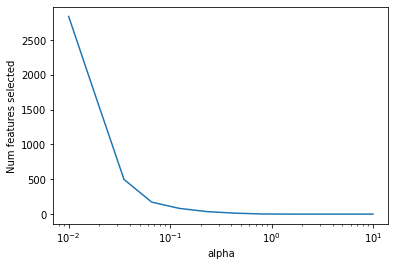

In [50]:
plt.plot(nonzero_by_alpha[:, 0], nonzero_by_alpha[:, 1])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Num features selected')
plt.savefig('M_features_v_alpha.pdf')
plt.show()

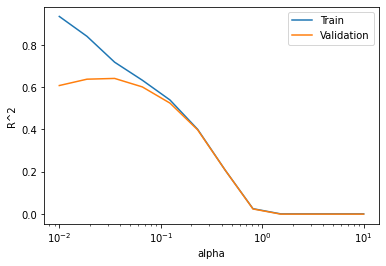

In [51]:
plt.clf()
plt.plot(train_val_scores_by_alpha[:, 0], train_val_scores_by_alpha[:, 1], label = 'Train')
plt.plot(train_val_scores_by_alpha[:, 0], train_val_scores_by_alpha[:, 2], label = 'Validation')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()
plt.savefig('M_train_val_vs_alpha.pdf')
plt.show()

## Same but for chicken data

  0%|          | 0/8 [00:00<?, ?it/s]/Users/noamringach/.conda/envs/cn_evolution/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1912: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04815470427274704, tolerance: 0.04520365968346596
  cd_fast.enet_coordinate_descent_multi_task(
 12%|█▎        | 1/8 [01:57<13:43, 117.64s/it]/Users/noamringach/.conda/envs/cn_evolution/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1912: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0506342351436615, tolerance: 0.04520365968346596
  cd_fast.enet_coordinate_descent_multi_task(
100%|██████████| 8/8 [05:13<00:00, 39.13s/it] 


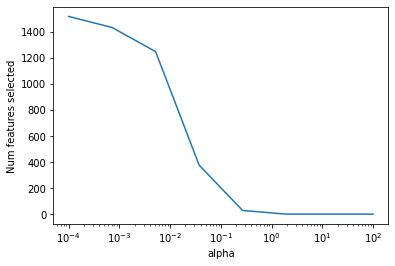

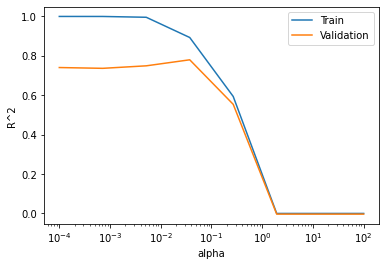

In [2]:
adata = sc.read('withcolors/chicken_ex_colors.h5ad')
adata.obs['subnuclei'] = adata.obs['clusters'].apply(lambda s: s.split('.')[0])
rng = np.random.default_rng(12345)
data = adata.X.toarray()
rng.shuffle(data)
num_train = int(data.shape[0] * 0.8)
data_train = data[:num_train]
data_val = data[num_train:]
n_obs = len(adata.obs.index)
label_to_id = {r: i for i, r in enumerate(np.unique(adata.obs['subnuclei']))}
rng = np.random.default_rng(12345)
labels = adata.obs['subnuclei'].map(label_to_id)
rng.shuffle(labels)
labels_train = labels[:num_train]
labels_val = labels[num_train:]
labels_expanded_train = np.zeros((len(labels_train), len(np.unique(labels_train))))
labels_expanded_train[np.arange((len(labels_train))), labels_train] = 1
labels_expanded_val = np.zeros((len(labels_val), len(np.unique(labels_val))))
labels_expanded_val[np.arange((len(labels_val))), labels_val] = 1
nonzero_by_alpha = []
train_val_scores_by_alpha = []
for alpha in tqdm(np.logspace(-4, 2, 8)):
    lasso = MultiTaskLasso(alpha=alpha, max_iter=10000).fit(data_train, labels_expanded_train)
    train_val_scores_by_alpha.append([alpha, lasso.score(data_train, labels_expanded_train), lasso.score(data_val, labels_expanded_val)])
    nonzero_by_alpha.append([alpha, (lasso.coef_ != 0).max(axis=0).sum()])
nonzero_by_alpha = np.array(nonzero_by_alpha)
train_val_scores_by_alpha = np.array(train_val_scores_by_alpha)
plt.plot(nonzero_by_alpha[:, 0], nonzero_by_alpha[:, 1])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Num features selected')
plt.savefig('C_features_v_alpha.pdf')
plt.show()
plt.clf()
plt.plot(train_val_scores_by_alpha[:, 0], train_val_scores_by_alpha[:, 1], label = 'Train')
plt.plot(train_val_scores_by_alpha[:, 0], train_val_scores_by_alpha[:, 2], label = 'Validation')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()
plt.savefig('C_train_val_vs_alpha.pdf')
plt.show()

## Multitask elastic-net

In [ ]:
adata = sc.read('withcolors/mouse_ex_colors.h5ad')
label = 'subnuclei'
# adata.obs['subnuclei'] = adata.obs['clusters'].apply(lambda s: s.split('.')[0])
rng = np.random.default_rng(12345)
data = adata.X.toarray()
# get count of number of occurrences of each label
label_to_count = adata.obs[label].value_counts(normalize=True).to_dict()
# Map each observation to its appropriate label appearance frequency
w = adata.obs[label].map(label_to_count)
# Diagonalize and take square root to appropraitely normalize data
w = np.diag(np.sqrt(w.to_numpy()))
# normalize data
data = np.matmul(w, data)
rng.shuffle(data)
num_train = int(data.shape[0] * 0.8)
data_train = data[:num_train]
data_val = data[num_train:]
n_obs = len(adata.obs.index)
label_to_id = {r: i for i, r in enumerate(np.unique(adata.obs['subnuclei']))}
rng = np.random.default_rng(12345)
labels = adata.obs['subnuclei'].map(label_to_id)
rng.shuffle(labels)
labels_train = labels[:num_train]
labels_val = labels[num_train:]
labels_expanded_train = np.zeros((len(labels_train), len(np.unique(labels_train))))
labels_expanded_train[np.arange((len(labels_train))), labels_train] = 1
labels_expanded_val = np.zeros((len(labels_val), len(np.unique(labels_val))))
labels_expanded_val[np.arange((len(labels_val))), labels_val] = 1
nonzero_by_alpha = []
train_val_scores_by_alpha = []
for alpha in tqdm(np.logspace(-2, 1, 12)):
    lasso = MultiTaskElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000).fit(data_train, labels_expanded_train)
    train_val_scores_by_alpha.append([alpha, lasso.score(data_train, labels_expanded_train), lasso.score(data_val, labels_expanded_val)])
    nonzero_by_alpha.append([alpha, (lasso.coef_ != 0).max(axis=0).sum()])
nonzero_by_alpha = np.array(nonzero_by_alpha)
train_val_scores_by_alpha = np.array(train_val_scores_by_alpha)
plt.plot(nonzero_by_alpha[:, 0], nonzero_by_alpha[:, 1])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Num features selected')
plt.savefig('M_ELASTIC_features_v_alpha.pdf')
plt.show()
plt.clf()
plt.plot(train_val_scores_by_alpha[:, 0], train_val_scores_by_alpha[:, 1], label = 'Train')
plt.plot(train_val_scores_by_alpha[:, 0], train_val_scores_by_alpha[:, 2], label = 'Validation')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()
plt.savefig('M_ELASTIC_train_val_vs_alpha.pdf')
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

## Multitask elastic-net for chicken

100%|██████████| 12/12 [01:15<00:00,  6.28s/it]


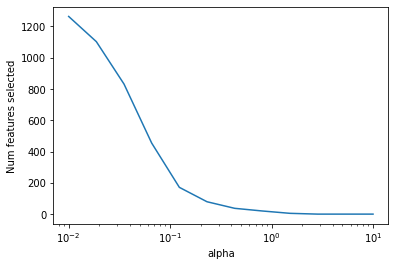

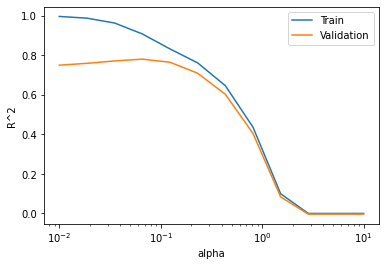

In [9]:
adata = sc.read('withcolors/chicken_ex_colors.h5ad')
adata.obs['subnuclei'] = adata.obs['clusters'].apply(lambda s: s.split('.')[0])
rng = np.random.default_rng(12345)
data = adata.X.toarray()
rng.shuffle(data)
num_train = int(data.shape[0] * 0.8)
data_train = data[:num_train]
data_val = data[num_train:]
n_obs = len(adata.obs.index)
label_to_id = {r: i for i, r in enumerate(np.unique(adata.obs['subnuclei']))}
rng = np.random.default_rng(12345)
labels = adata.obs['subnuclei'].map(label_to_id)
rng.shuffle(labels)
labels_train = labels[:num_train]
labels_val = labels[num_train:]
labels_expanded_train = np.zeros((len(labels_train), len(np.unique(labels_train))))
labels_expanded_train[np.arange((len(labels_train))), labels_train] = 1
labels_expanded_val = np.zeros((len(labels_val), len(np.unique(labels_val))))
labels_expanded_val[np.arange((len(labels_val))), labels_val] = 1
nonzero_by_alpha = []
train_val_scores_by_alpha = []
for alpha in tqdm(np.logspace(-2, 1, 12)):
    lasso = MultiTaskElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000).fit(data_train, labels_expanded_train)
    train_val_scores_by_alpha.append([alpha, lasso.score(data_train, labels_expanded_train), lasso.score(data_val, labels_expanded_val)])
    nonzero_by_alpha.append([alpha, (lasso.coef_ != 0).max(axis=0).sum()])
nonzero_by_alpha = np.array(nonzero_by_alpha)
train_val_scores_by_alpha = np.array(train_val_scores_by_alpha)
plt.plot(nonzero_by_alpha[:, 0], nonzero_by_alpha[:, 1])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Num features selected')
plt.savefig('C_ELASTIC_features_v_alpha.pdf')
plt.show()
plt.clf()
plt.plot(train_val_scores_by_alpha[:, 0], train_val_scores_by_alpha[:, 1], label = 'Train')
plt.plot(train_val_scores_by_alpha[:, 0], train_val_scores_by_alpha[:, 2], label = 'Validation')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()
plt.savefig('C_ELASTIC_train_val_vs_alpha.pdf')
plt.show()

In [17]:
subnucleus_to_count = adata.obs['subnuclei'].value_counts(normalize=True).to_dict()

In [23]:
np.diag(np.sqrt(adata.obs['subnuclei'].map(subnucleus_to_count)))

array([[0.36436921, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        ,        nan, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.38548576, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.36436921, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.36436921,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.36436921]])